# Proof: Comparing OOD scores vs true effect sizes

What we are doing:
1. Data generated as          : $p(y) = f(l_d , c_k)$
2. Model expected to learn    : $p(y|L) = f(l_d , l_{c_k})$ this generates $\hat{y}$
3. Mechanistic XAI methods expected to recover  : $p(\hat{y}|X) = f(l_d , c_k)$

Investigate: how to use OOD accuracies?<br>

We are interested in $\hat{\beta}$ and $\hat{\gamma}$ that we could derive using $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\gamma} \cdot c_k$ in the current simplest case where,
1. $C^{con} = \{c_k\}$, that is, $|C^{con}| = 1$
2. $c_k \in \mathbb{R}$
3. $l_{c_k} \in \mathbb{R}$ 
4. $l_{dir} \in \mathbb{R}$
5. $\epsilon=0$ in the true data gen. process $p(y) = \sigma(\beta \cdot l_{dir} + \gamma \cdot c_k + \epsilon)$
6. the model used $f_{\Theta}: L \Rightarrow y$ is a log. reg. trained on $L$.

Lets check the correlation between the different OOD metrics $A$ with $\{\hat{\beta}, \hat{\gamma}\}$ to determine which metric :
$$\frac{A_{total} - A_{total \setminus dir}}{A_{total} -A_{\varnothing}} \propto \hat{\beta}$$ 

$$\frac{A_{total} - A_{total \setminus con}}{A_{total} -A_{\varnothing}} \propto \hat{\gamma}$$ 
$$\forall A  \in \{\text{balanced-accuracy}, D^2, \text{logodds-}R^2, \text{logodds-MSE}, \text{logodds-MAE}\}$$

Lets measure the $\propto$ using spearman's rank correlation

### Import libs

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# print date and time
from datetime import datetime
start_time = datetime.now()
print("Notebook started on {}".format(str(start_time).split(".")[0]))


Notebook started on 2025-03-31 15:51:17


In [2]:
# standard python packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import statsmodels.api as sm
from io import StringIO
import importlib
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_selector


# import utils
TOYBRAINS_DIR = os.path.abspath('../../')
if TOYBRAINS_DIR not in sys.path: sys.path.append(TOYBRAINS_DIR)
from utils.genutils_all import *

## Helper functions

In [3]:
def log_odds(p):
    """Convert probability to log-odds."""
    # if p is in range [0,100] convert it to [0,1]
    if np.max(p) > 1: p = p / 100
    # first handle extreme cases of p=0 and p=1 to avoid log(0) and division by zero
    p = np.clip(p, 1e-6, 1-(1e-6))
    return np.log(p / (1 - p))

def load_config(dataset):
    """Load configuration module for the dataset."""
    config_file = '_'.join(dataset.split("_")[2:])
    if 'configs' not in sys.path:
        sys.path.append('configs')
    return importlib.import_module(config_file)

def preprocess_columns(df, column_prefixes):
    """Extract and preprocess columns based on prefixes."""
    columns = {prefix.strip('_'): [col for col in df.columns if col.startswith(prefix)] for prefix in column_prefixes}
    columns["lat"] = [col for col in df.columns if col not in sum(columns.values(), [])]
    return columns


def preprocess(df_X):
    # preprocess the X features
    cat_col_names_selector = make_column_selector(dtype_include=object)
    cat_col_names = cat_col_names_selector(df_X)
    categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

    cont_col_names_selector = make_column_selector(dtype_exclude=object)
    cont_col_names = cont_col_names_selector(df_X)
    continuous_preprocessor = StandardScaler()

    preprocessor = ColumnTransformer([
                    ("one-hot-encoder", categorical_preprocessor, cat_col_names),
                    ("minmax_scaler", continuous_preprocessor, cont_col_names),
                    ], verbose_feature_names_out=False)

    # get feature names after preprocessing
    preprocessor = preprocessor.fit(df_X)
    X_names_out = preprocessor.get_feature_names_out()
    # print(len(L_names_out))
    X_proc = preprocessor.transform(df_X)
    return X_proc, X_names_out
    
def preprocess_data(df, columns, config):
    """Filter and preprocess columns based on the configuration."""
    lat_direct = config.LATENTS_DIRECT
    cons = config.CONFOUNDERS + config.MEDIATORS
    lats_indirect = [l for c, l in config.COV_TO_LATENTS.items() if c in cons]
    
    y = df[columns['lbl'][0]]
    y_proc = OneHotEncoder().fit_transform(y.values.reshape(-1, 1)).toarray()
    y_proba = df[f"probas_{columns['lbl'][0]}"].apply(lambda x: eval(x)[-1]).values
    y_logodds = log_odds(y_proba)
    
    C = df[columns['cov']]
    L = df[columns['lat']]
    
    C_filtered = C[[col for col in C.columns if col in cons]]
    L_dir = L[[col for col in L.columns if col in lat_direct]]
    L_indir = L[[col for col in L.columns if col in lats_indirect]]
    
    C_proc, C_proc_names = preprocess(C_filtered)
    L_dir_proc, L_dir_proc_names = preprocess(L_dir)
    L_indir_proc, L_indir_proc_names = preprocess(L_indir)
    names = {"C": C_proc_names.tolist(), 
            "L_dir": L_dir_proc_names.tolist(), 
            "L_indir": L_indir_proc_names.tolist()}
    
    return y_proc, y_logodds, C_proc, L_dir_proc, L_indir_proc, names

def fit_glm(X, y, column_names):
    """Fit GLM and filter significant coefficients."""
    column_names = list(column_names)
    try:
        # add an intercept term
        X = sm.add_constant(X)
        model = sm.GLM(y, X)
        summary = model.fit().summary(xname=['intercept']+column_names)
        
        # display(summary)
        # collect the estimated coefficients and their standard errors in a pandas dataframe
        df_coef = pd.read_html(StringIO(summary.tables[1].as_html()), header=0, index_col=0)[0]
        # also collect all the results in the attributes as a dictionary
        attrs = {}
        for k1,v1,k2,v2 in summary.tables[0].data:
            attrs[k1.strip().rstrip(':')] = v1.strip()
            attrs[k2.strip().rstrip(':')] = v2.strip()
        # drop the intercept term
        df_coef = df_coef.drop('intercept')
        # if the coefficients are not significantly better than 0 then force them to 0
        df_coef.loc[df_coef['P>|z|'] > 0.05, 'coef'] = 0

        # return effect_sizes, std_errors, and the summary attributes as dicts
        effect_sizes = df_coef['coef'].to_dict()
        std_errors = df_coef['std err'].to_dict()

        return effect_sizes, std_errors, attrs  
        
    except Exception as e:
        print(f"[WARN] Failed to fit GLM from X({column_names})--> y.")
        if 'deviance function returned a nan' in str(e):
            print("Forcing all coefficients to 0.")
            effect_sizes = {c:0 for c in column_names}
            std_errors   = {c:0 for c in column_names}
            return effect_sizes, std_errors, {}
        else: # raise the exception if its something unexpected
            raise e


def get_true_effects(dataset):
    """Extract true effects from the dataset name."""
    n_covs, cons, cX, cy, Xy, _ = break_dataset_name(dataset)
    proba_to_eff = lambda p: log(p/100/(1-p/100))
    return {r"$\alpha_{true}$": proba_to_eff(cX), r"$\gamma_{true}$": proba_to_eff(cy), r"$\beta_{true}$": proba_to_eff(Xy)}

def rename_results(coefs, stderrs, names,
                   other={}, 
                   append_var_name=True, suffix="",
                   add_hat=False):
    """Update result dictionary with parameter estimates and standard errors."""
    r = {}
    for k, v in coefs.items():
        full_suffix = suffix + f" ({k})" if append_var_name else suffix
        if k in names['L_dir']:
            eff_name = r"$\beta$" if not add_hat else r"$\hat{\beta}$"
        elif k in names['C']:
            eff_name = r"$\gamma$" if not add_hat else r"$\hat{\gamma}$"
        elif k in names['L_indir']:
            eff_name = r"$\theta$" if not add_hat else r"$\hat{\theta}$"
        else:
            print(f"[WARN] Variable '{k}' not found in latents or confounders. Not saving it.")
            continue # skip the variable
        
        r[eff_name + f"{full_suffix}"] = v

    for k, v in stderrs.items():
        full_suffix = suffix + f" ({k})" if append_var_name else suffix
        if k in names['L_dir']:
            eff_name = r"$\beta$" if not add_hat else r"$\hat{\beta}$"
        elif k in names['C']:
            eff_name = r"$\gamma$" if not add_hat else r"$\hat{\gamma}$"
        elif k in names['L_indir']:
            eff_name = r"$\theta$" if not add_hat else r"$\hat{\theta}$"
        else:
            continue 
            # print(f"[WARN] Variable '{k}' not found in latents or confounders. Not saving it.") # print warning only once for the coefs above
        # add stderr to the end of the name
        r[eff_name + f"{full_suffix} stderr"] = v

    for k, v in other.items():
        r[f"{k}{suffix}"] = v

    return r

In [4]:
def compute_OOD_scores(A_total, A_total_minus_dir, A_total_minus_con, A_none, metric='$R^2$'):
    """Compute OOD scores A_dir, A_con resp. from A_total."""
    scores = {}
    den =  A_total - A_none
    scores[r'$A_{dir}$'] = (A_total - A_total_minus_dir) / den
    scores[r'$A_{con}$'] = (A_total - A_total_minus_con) / den
    # add more things for comparison 
    # scores[r'$A_{total \setminus dir}$'] = A_total_minus_dir
    # scores[r'$A_{total \setminus con}$'] = A_total_minus_con
    # if 'mse' in metric:
    #     A_total_max = -25
    #     A_total_min = -25
    # elif 'mae' in metric:
    #     A_total_max = -5
    #     A_total_min = -5
    # elif 'accuracy' in metric:
    #     A_total_max = 1
    #     A_total_min = 0.5
    # else: # 'R^2' in metric:
    #     A_total_max = 1 
    #     A_total_min = 0
    # scores[r'$A_{total}$ (scaled)'] = (A_total - A_total_min) / A_total_max
    # scores[r'$A_{\varnothing} (scaled)$'] = A_none / A_total_max
    # scores[r'$(A_{dir} + A_{con})$'] =  (scores[r'$A_{dir}$'] + scores[r'$A_{con}$'])
    # scores[r'$A_{total \setminus dir} - A_{\varnothing}$'] = A_total_minus_dir - A_none
    # scores[r'$A_{total \setminus con} - A_{\varnothing}$'] = A_total_minus_con - A_none
    return scores


In [5]:
def process_dataset(dataset_dir, split_train=True, split_test=True, polydegree=2, 
                    append_var_name=True,
                    verbose=0):
    """Process individual datasets."""
    dataset = os.path.basename(dataset_dir)
    true_effects = get_true_effects(dataset)
    config = load_config(dataset)
    splits = ['train'] if split_train else [] + ['test_all'] if split_test else []
    results = []
    
    if verbose > 0: print(f"{'-'*100}\nProcessing dataset: {dataset}...")

    if polydegree > 0:
        # if polydegree is 1 then interaction_only=True
        interaction_only = True if polydegree ==1 else False 
        polyfea = PolynomialFeatures(degree=polydegree, interaction_only=interaction_only, include_bias=False)

    for split in splits:
        result = {'dataset': dataset, 'split': split, **true_effects}

        df_data = pd.read_csv(f"{dataset_dir}/{split}/{dataset}.csv", index_col='subjectID')

        columns = preprocess_columns(df_data, ['cov_', 'lbl_'])
        y, y_logodds, C, L_dir, L_indir, names = preprocess_data(df_data, columns, config)
        if verbose > 0: print(f"nodes of the causal graph: {names}")
        
        ## (1a) Fit GLM to model logodds(y) ~ beta.L_dir + gamma.C
        LC = np.hstack([L_dir, C])
        LC_names = names['L_dir'] + names['C']
        gamma_params, gamma_stderr, gamma_attrs = fit_glm(LC, y_logodds, column_names=LC_names)
        r2_lc = gamma_attrs['Pseudo R-squ. (CS)'] if bool(gamma_attrs) else np.nan
        # save the gamma estimations and their standard errors in the result, along with the model accuracy
        result.update(rename_results(gamma_params, gamma_stderr, names,
                                    append_var_name=append_var_name,
                                    other={'$R^2$': r2_lc},
                                    suffix=r" from (1) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \gamma \cdot c_k$")
                    )

        ## (1b) Fit GLM to model logodds(y) ~ beta.L_dir + theta.L_indir
        L = np.hstack([L_dir, L_indir])
        L_names = names['L_dir'] + names['L_indir']
        theta_coefs, theta_stderrs, theta_attrs = fit_glm(L, y_logodds, column_names=L_names)
        r2_l = theta_attrs['Pseudo R-squ. (CS)'] if bool(theta_attrs) else np.nan
        # save the theta estimations and their standard errors in the result, along with the model accuracy
        result.update(rename_results(theta_coefs, theta_stderrs, names,
                                    append_var_name=append_var_name,
                                    other={'$R^2$': r2_l}, 
                                    suffix=r" from (2) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \theta \cdot l_{c_k}$")
                    )
            
        ## (1c) Fit GLM to model logodds(y) ~ polynomial(L_dir + L_indir)
        # if polydegree > 0:
        #     L_poly = polyfea.fit_transform(L)
        #     L_poly_names = polyfea.get_feature_names_out(input_features=L_names)
        #     polytheta_params, polytheta_stderr, polytheta_attrs = fit_glm(L_poly, y_logodds, column_names=L_poly_names)
        #     r2_lpoly = polytheta_attrs['Pseudo R-squ. (CS)'] if bool(polytheta_attrs) else np.nan
        #     # save the gamma estimations and their standard errors in the result, along with the model accuracy
        #     result.update(rename_results(polytheta_params, polytheta_stderr, names,
        #                                 append_var_name=append_var_name,
        #                                 other={'$R^2$': r2_lpoly}, 
        #                                 suffix=f" from $\\sigma^{{-1}}p(y) = (l_{{dir}},l_{{c_k}})^{polydegree}$")
        #             )

        ## (2) On the model predictions fit a GLM to model logodds(y_hat) ~ beta_hat.L_dir + gamma_hat.C 
        # get the model predictions y_pred from results csv
        df_ml_results = pd.read_csv(f"{dataset_dir}/baseline_results.csv")
        y_pred = np.array([eval(y_pred_probas_cvi) for y_pred_probas_cvi in df_ml_results['y_pred_probas_holdout_test-all'].values])
        y_pred_logodds = log_odds(y_pred)

        
        # also get the accuraries A_total, A_dir, A_conf computed with different metrics
        scores_cols = df_ml_results.columns[df_ml_results.columns.str.startswith('score_holdout_test-')]
        scores = {}
        for col_name in scores_cols:
            test_type, metric = col_name.replace('score_holdout_test-', '').split('_')
            # add the metric to the scores dict if not already there
            if metric not in scores: scores[metric] = {}
            # remap test_type to A_total, A_dir, A_conf
            test_type_grp = ''
            if test_type == 'all': test_type_grp = r'raw_$A_{total}$'
            if test_type == 'none': test_type_grp = r'raw_$A_{\varnothing}$'
            for c in names['C']:
                if test_type in c.replace('_', '-'):
                    test_type_grp = r'raw_$A_{total \setminus con}$'
            for l in names['L_dir']:
                if test_type in l.replace('_', '-'):
                    test_type_grp = r'raw_$A_{total \setminus dir}$'
            # skip if the test_type is not in the latents or confounders or total
            if test_type_grp == '': 
                if verbose>0: print(f"[WARN] '{col_name}' belongs neither to A_total, A_conf, or A_dir. Skipping.")
                continue 
            scores[metric][test_type_grp] = df_ml_results[col_name].mean().item()
            # save the raw scores also in the output
            result.update({f"{metric}__{test_type_grp}": scores[metric][test_type_grp]})
        
        # From the A_{total \setminus con} , A_{total \setminus dir} compute the A_{conf}, A_{dir} scores using the A_{total} and/or A_{\varnothing}.
        for metric, scores_dict in scores.items():
            OOD_scores = compute_OOD_scores(A_total=scores_dict[r'raw_$A_{total}$'], 
                                            A_total_minus_dir=scores_dict[r'raw_$A_{total \setminus dir}$'],
                                            A_total_minus_con=scores_dict[r'raw_$A_{total \setminus con}$'],
                                            A_none=scores_dict[r'raw_$A_{\varnothing}$'],
                                            metric=metric)
            for score_name, score_val in OOD_scores.items():
                result.update({f"{metric}__{score_name}": score_val})      

        
        thetahat_params, thetahat_stderr, thetahat_attrs = [], [], []
        gammahat_params, gammahat_stderr, gammahat_attrs = [], [], []
        polygammahat_params, polygammahat_stderr, polygammahat_attrs = [], [], []
        for cv_idx, y_pred_logodds_cvi in enumerate(y_pred_logodds):
            ## (2a) fit the GLM model on logodds(p(y_hat)) ~ L_dir + L_indir
            thetahat_params_i, thetahat_stderr_i, thetahat_attrs_i = fit_glm(L, y_pred_logodds_cvi, column_names=L_names)
            thetahat_params.append(thetahat_params_i)
            thetahat_stderr.append(thetahat_stderr_i)
            thetahat_attrs.append(thetahat_attrs_i)

            ## (2b) fit the GLM model on logodds(p(y_hat)) ~ L + C
            gammahat_params_i, gammahat_stderr_i, gammahat_attrs_i = fit_glm(LC, y_pred_logodds_cvi, column_names=LC_names)
            gammahat_params.append(gammahat_params_i)
            gammahat_stderr.append(gammahat_stderr_i)
            gammahat_attrs.append(gammahat_attrs_i)

            ## (2c) fit the GLM model on logodds(p(y_hat))  ~ polynomial(L + C)
            if polydegree > 0:
                LC_poly = polyfea.fit_transform(LC)
                LC_poly_names = polyfea.get_feature_names_out(input_features=LC_names)
                gammahat_params_i, gammahat_stderr_i, gammahat_attrs_i = fit_glm(LC_poly, y_pred_logodds_cvi, column_names=LC_poly_names)
                polygammahat_params.append(gammahat_params_i)
                polygammahat_stderr.append(gammahat_stderr_i)
                polygammahat_attrs.append(gammahat_attrs_i)

        # average everything over the cross-validation folds and save the results
        thetahat_params = {k: np.mean([d[k] for d in thetahat_params]) for k in thetahat_params[0]}
        thetahat_stderr = {k: np.mean([d[k] for d in thetahat_stderr]) for k in thetahat_stderr[0]}
        r2_l  = [d['Pseudo R-squ. (CS)'] for d in thetahat_attrs if bool(d)]
        result.update(rename_results(thetahat_params, thetahat_stderr, names, 
                                    other={'$R^2$': np.array(r2_l).astype(float).mean()}, 
                                    append_var_name=append_var_name,
                                    add_hat=True,
                                    suffix=r" from (3) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\theta} \cdot l_{c_k}$"))
                                    
        gammahat_params = {k: np.mean([d[k] for d in gammahat_params]) for k in gammahat_params[0]}
        gammahat_stderr = {k: np.mean([d[k] for d in gammahat_stderr]) for k in gammahat_stderr[0]}
        r2_lc = [d['Pseudo R-squ. (CS)'] for d in gammahat_attrs if bool(d)]
        result.update(rename_results(gammahat_params, gammahat_stderr, names,
                                    append_var_name=append_var_name,
                                    other={'$R^2$': np.array(r2_lc).astype(float).mean()},
                                    add_hat=True,
                                    suffix=r" from (4) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\gamma} \cdot c_k$"))

        if polydegree > 0:
            polygammahat_params = {k: np.mean([d[k] for d in polygammahat_params]) for k in polygammahat_params[0]}
            polygammahat_stderr = {k: np.mean([d[k] for d in polygammahat_stderr]) for k in polygammahat_stderr[0]}
            r2_lcpoly = [d['Pseudo R-squ. (CS)'] for d in polygammahat_attrs if bool(d)]
            result.update(rename_results(polygammahat_params, polygammahat_stderr, names,
                                        append_var_name=append_var_name,
                                        other={'$R^2$': np.array(r2_lcpoly).astype(float).mean()},
                                        add_hat=True,
                                        suffix=f" from $\\sigma^{{-1}}p(\\hat{{y}}) = (l_{{dir}},c_k)^{polydegree}$"))
        
        results.append(result)
    
    return results

## Main execution

In [7]:
# get a list of the different datasets available and choose one
def get_unique_dataset_name(f):
    f = os.path.basename(f)
    ncons, cons, _, _, _, _ = break_dataset_name(f)
    out = f"con{ncons}"
    for c in cons:
        out += f"_{c.replace('_','-')}"
    return out
    
datasets = sorted(list(set([get_unique_dataset_name(f) for f in glob("dataset/toybrains_n*")])))
print("Datasets available are: {}".format(datasets))
# ask users to choose one
dataset = input("Enter the dataset name to process: ")
if dataset not in datasets:
    print(f"Invalid dataset name '{dataset}'. Selecting the first dataset in the list '{datasets[0]}' instead.")
    dataset = datasets[0]

ValueError: invalid literal for int() with base 10: 'cy067'

In [ ]:
# Global parameters
verbose = 0
split_train = False
split_test = True
polydegree = 0

In [ ]:
# Main execution
df_out = []
for dataset_dir in glob(f"dataset/toybrains_n*{dataset}*"):
    out = process_dataset(dataset_dir, 
                        split_train=split_train, split_test=split_test, 
                        polydegree=polydegree,
                        append_var_name=False, 
                        verbose=verbose)
    df_out.extend(out)

df_out = pd.DataFrame(df_out)

df_out = df_out.set_index(['dataset', 'split']).sort_index()
# sort columns alphabetically and convert to float
df_out = df_out.reindex(sorted(df_out.columns), axis=1).astype(float)
# sort rows by the true alpha, gamma, beta respectively
df_out = df_out.sort_values([r'$\beta_{true}$', r'$\gamma_{true}$', r'$\alpha_{true}$'])

# also compute the scaled hat{beta} and hat{gamma} to compare the OOD scores with 
df_out[r'$\hat{\beta}$ (scaled)'] = df_out[r'$\hat{\beta}$ from (4) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\gamma} \cdot c_k$'].copy()
df_out[r'$\hat{\gamma}$ (scaled)'] = df_out[r'$\hat{\gamma}$ from (4) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\gamma} \cdot c_k$'].copy() 
df_out[r'$\hat{\beta}$ (scaled)'] /= ( df_out[[r'$\hat{\beta}$ (scaled)', r'$\hat{\gamma}$ (scaled)']].sum(axis=1) + 1e-6)
df_out[r'$\hat{\gamma}$ (scaled)'] /= ( df_out[[r'$\hat{\beta}$ (scaled)', r'$\hat{\gamma}$ (scaled)']].sum(axis=1) + 1e-6)

display(df_out)

/ritter/roshan/installation/miniforge3/envs/toy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:188: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


[WARN] Failed to fit GLM from X(['shape-midr_vol', 'cov_40_cont'])--> y.
Forcing all coefficients to 0.
[WARN] Failed to fit GLM from X(['shape-midr_vol', 'shape-botr_vol'])--> y.
Forcing all coefficients to 0.


/ritter/roshan/installation/miniforge3/envs/toy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:188: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


[WARN] Failed to fit GLM from X(['shape-midr_vol', 'cov_40_cont'])--> y.
Forcing all coefficients to 0.
[WARN] Failed to fit GLM from X(['shape-midr_vol', 'shape-botr_vol'])--> y.
Forcing all coefficients to 0.


/ritter/roshan/installation/miniforge3/envs/toy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:188: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


[WARN] Failed to fit GLM from X(['shape-midr_vol', 'cov_40_cont'])--> y.
Forcing all coefficients to 0.
[WARN] Failed to fit GLM from X(['shape-midr_vol', 'shape-botr_vol'])--> y.
Forcing all coefficients to 0.


/ritter/roshan/installation/miniforge3/envs/toy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:188: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


[WARN] Failed to fit GLM from X(['shape-midr_vol', 'cov_40_cont'])--> y.
Forcing all coefficients to 0.
[WARN] Failed to fit GLM from X(['shape-midr_vol', 'shape-botr_vol'])--> y.
Forcing all coefficients to 0.


,,$R^2$ from (1) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \gamma \cdot c_k$,$R^2$ from (2) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \theta \cdot l_{c_k}$,$R^2$ from (3) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\theta} \cdot l_{c_k}$,$R^2$ from (4) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\gamma} \cdot c_k$,$\alpha_{true}$,$\beta$ from (1) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \gamma \cdot c_k$,$\beta$ from (1) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \gamma \cdot c_k$ stderr,$\beta$ from (2) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \theta \cdot l_{c_k}$,$\beta$ from (2) $\sigma^{-1}p(y) = \beta \cdot l_{dir} + \theta \cdot l_{c_k}$ stderr,$\beta_{true}$,...,logodds-mse__raw_$A_{total \setminus dir}$,logodds-mse__raw_$A_{total}$,logodds-r2__$A_{con}$,logodds-r2__$A_{dir}$,logodds-r2__raw_$A_{\varnothing}$,logodds-r2__raw_$A_{total \setminus con}$,logodds-r2__raw_$A_{total \setminus dir}$,logodds-r2__raw_$A_{total}$,$\hat{\beta}$ (scaled),$\hat{\gamma}$ (scaled)
dataset,split,,,,,,,,,,,,,,,,,,,,,
toybrains_n5000_con1_cov-40-cont_cX050_cy050_Xy050,test_all,NaN,NaN,0.011362,0.009451,0.000000,0.0000,0.000,0.0000,0.000,0.000000,...,21.144571,21.208584,-0.403669,-0.758086,-0.008236,-0.002978,-0.001651,-0.004490,0.999852,0.000000
toybrains_n5000_con1_cov-40-cont_cX067_cy050_Xy050,test_all,NaN,NaN,0.052082,0.051036,0.708185,0.0000,0.000,0.0000,0.000,0.000000,...,21.088221,21.180614,-0.258512,-1.122578,-0.012745,-0.005800,-0.001032,-0.007227,-1.045302,-0.025649
toybrains_n5000_con1_cov-40-cont_cX081_cy050_Xy050,test_all,NaN,NaN,0.078009,0.076321,1.450010,0.0000,0.000,0.0000,0.000,0.000000,...,21.204413,21.174361,2.218389,-0.028833,-0.001869,0.001230,-0.004486,-0.004412,1.000020,0.000000
toybrains_n5000_con1_cov-40-cont_cX092_cy050_Xy050,test_all,NaN,NaN,0.109856,0.105216,2.442347,0.0000,0.000,0.0000,0.000,0.000000,...,21.204079,21.069496,1.015586,0.556124,-0.009301,-0.009477,-0.004277,0.002017,0.563181,0.058369
toybrains_n5000_con1_cov-40-cont_cX050_cy067_Xy050,test_all,1.0000,0.1149,0.814690,0.051373,0.000000,0.0000,0.000,0.0000,0.032,0.000000,...,20.861365,20.761054,0.731227,0.410368,-0.007331,-0.000858,0.006870,0.016753,0.000000,0.999985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
toybrains_n5000_con1_cov-40-cont_cX092_cy081_Xy092,test_all,0.9937,0.9788,1.000000,1.000000,2.442347,3.0781,0.075,3.1537,0.084,2.442347,...,23.585218,11.266677,0.159961,0.705072,-0.365221,0.333208,-0.120011,0.466203,0.671010,0.618404
toybrains_n5000_con1_cov-40-cont_cX050_cy092_Xy092,test_all,0.9978,0.5538,1.000000,0.990980,0.000000,3.8032,0.092,3.5957,0.182,2.442347,...,23.268007,17.492582,-0.171531,1.232735,-0.051276,0.209537,-0.103089,0.171349,0.904514,0.124156
toybrains_n5000_con1_cov-40-cont_cX067_cy092_Xy092,test_all,0.9990,0.7811,1.000000,0.980910,0.708185,4.2487,0.102,4.3742,0.180,2.442347,...,22.266482,13.892936,0.349347,0.882707,-0.109780,0.183209,-0.056963,0.340519,0.748628,0.399318


### Display results

In [ ]:
# Display results with matplotlib line plots
plot_scores = True
# from the index drop the split column
df_out_plt = df_out.reset_index().set_index('dataset')
unique_metrics = list(set([s.split('__')[0] for s in df_out_plt.filter(like=r'$A_{').columns]))

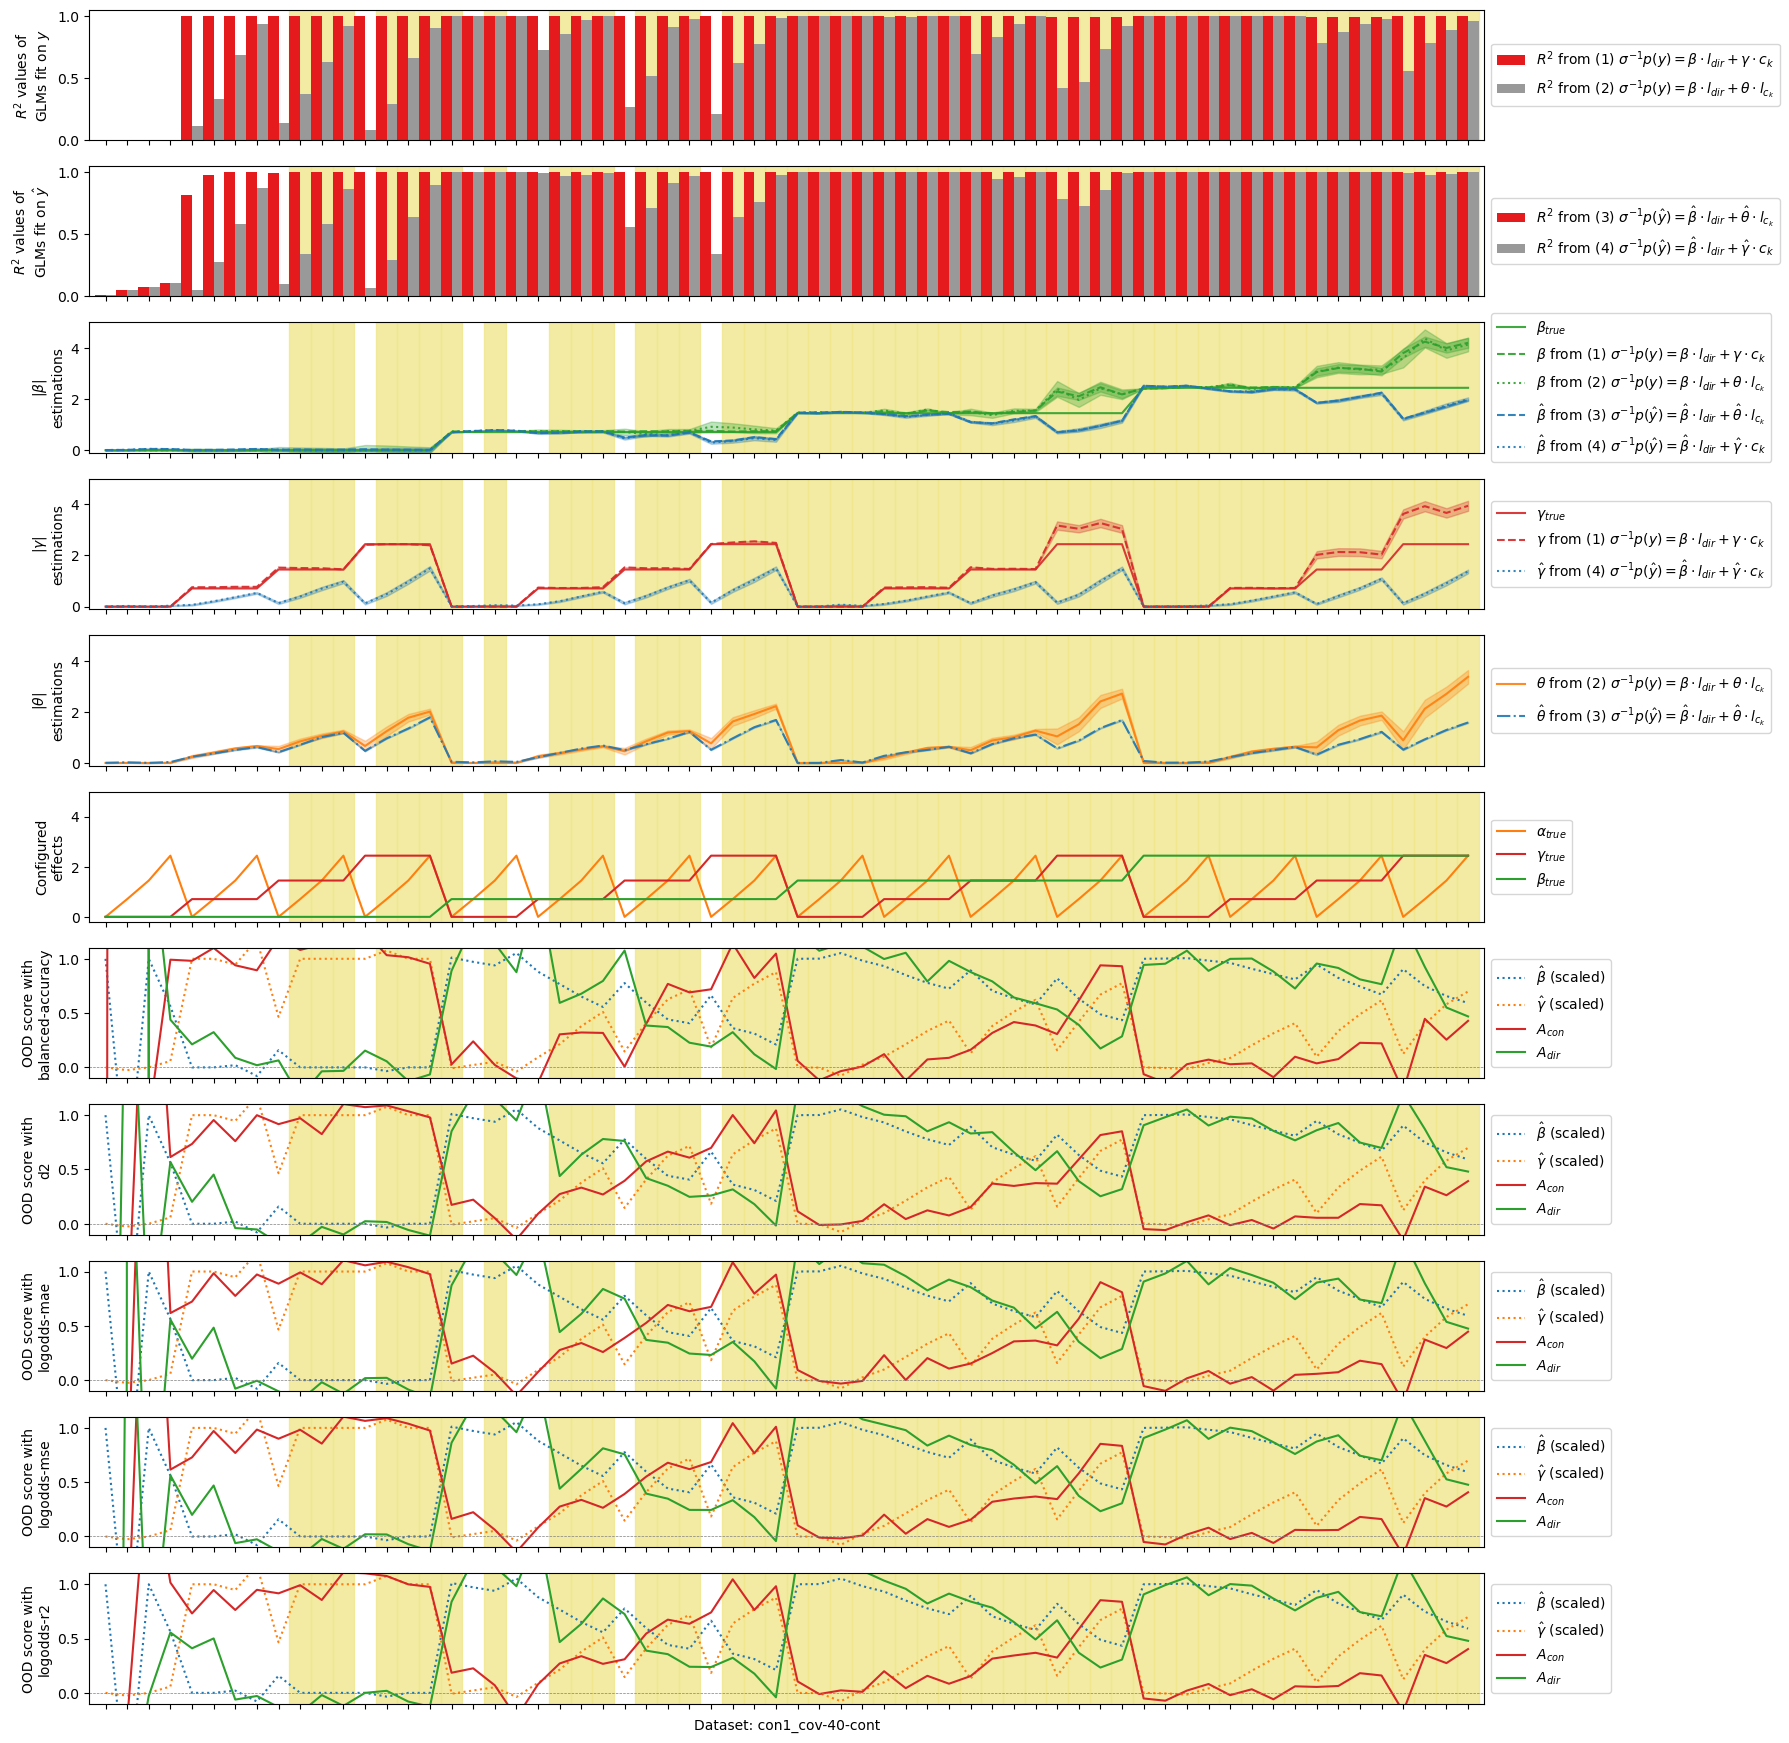

In [ ]:
# create a figure and a grid of subplots
scr_subplots =len(unique_metrics) if plot_scores else 0
    
fig, axs = plt.subplots(6+scr_subplots, 1, figsize=(18, 12+2*scr_subplots), 
                        sharex=True, sharey=False)
axs = axs.ravel()

# choose one color for beta, gamma, theta and alpha values
colormap = {'beta': 'tab:green', 'gamma': 'tab:red',
            'alpha': 'tab:orange', 'theta': 'tab:orange',
            'hat': 'tab:blue'}
linestyles = ['-', '--', '-.', ':']

### 0) Select a subset of the datasets that are identifiable
# get the dataset settings (position on the x axis) where the R2~1.0 for the GLM (4) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\gamma} \cdot c_k$
# datasets_selected = df_out_plt[r"$R^2$ from (4) $\sigma^{-1}p(\hat{y}) = \hat{\beta} \cdot l_{dir} + \hat{\gamma} \cdot c_k$"].fillna(
#     0).astype(float).apply(lambda x: x > 0.95)
# also the alpha should be higher than 1.0
# select datasets where A_\varnothing is close to 0.0 and A_total is higher than 10%
datasets_selected = (df_out_plt["logodds-r2__raw_$A_{total}$"] > df_out_plt["logodds-r2__raw_$A_{\\varnothing}$"] + 0.1) # a bool series with index as the dataset names
# # get the index point (arg) where the datasets_selected is True
datasets_selected_idx = datasets_selected.reset_index()[datasets_selected.reset_index(drop=True)].index.tolist()
# print(datasets_selected, datasets_selected_idx)

# # apply a yellow background to the datasets that have been filtered for all subplots
for ax in axs:
    for i in datasets_selected_idx:
        ax.axvspan(i-0.5, i+0.5, color='khaki', alpha=0.8)


### 1) plot the R2 accuracy on y in the top subplot and the R2 accuracy on y_hat in the second subplot
R2_cols = [c for c in df_out_plt.columns if '$R^2$' in c and 'hat' not in c]
R2_cols_hat = [c for c in df_out_plt.columns if '$R^2$' in c and 'hat' in c]

df_out_plt[R2_cols].fillna(0).astype(float).plot(kind='bar', ax=axs[0], 
                                                           ylabel='$R^2$ values of \nGLMs fit on $y$', 
                                                           colormap='Set1', width=1)
df_out_plt[R2_cols_hat].fillna(0).astype(float).plot(kind='bar', ax=axs[1], 
                                                           ylabel='$R^2$ values of \nGLMs fit on $\\hat{{y}}$', 
                                                           colormap='Set1', width=1)


### 2) plot the beta, gamma and theta coefficients in the next three subplots
for i, regex in enumerate(["beta", "gamma", "theta"]):
    cols_selected = sorted([c for c in df_out_plt.columns if (c.startswith('$\\'+regex) or c.startswith('$\\hat{\\'+regex)) and ('(scaled)' not in c)])
    assert len(cols_selected) > 0, f"No columns matched for the regex: {regex} among the columns: {df_out_plt.columns.tolist()}"
    # sort the columns selected to first have _{true} values, then have values without \hat and then have values with \hat
    cols_selected = sorted(cols_selected, key=lambda x: ('true' not in x, '\\hat' in x))
    ax = axs[i+2]

    for j, col in enumerate(cols_selected):
        if 'stderr' not in col and '$R^2$' not in col: 
            # make the values absolute for ease-of-plotting HACK
            df_out_plt[col] = df_out_plt[col].abs()
            ylim_min = -0.1
            # for est made on model predictions \hat{y} use a different color
            color = colormap['hat'] if 'hat' in col else  colormap[regex] 
            df_out_plt[col].plot(color=color, kind='line', ax=ax, linestyle=linestyles[j%len(linestyles)], label=col,
                                 alpha=0.9)
            
            # if stderr is available then convert it to stddev and add as an error bar using fill_between 
            if f"{col} stderr" in df_out_plt.columns:
                std_err = df_out_plt[f"{col} stderr"].values
                ax.fill_between(df_out_plt.index, df_out_plt[col]-std_err*1.96, df_out_plt[col]+std_err*1.96, 
                                    color=color, alpha=0.3)
    # convert coef to latex
    regex = regex.replace('alpha', r'$|\alpha|$').replace('beta', r'$|\beta|$').replace('gamma', r'$|\gamma|$').replace('theta', r'$|\theta$|')
    ax.set_ylabel(f'{regex}\nestimations')
    # ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_ylim(ylim_min,5)

## 3) plot the true effects configured in the final subplot
ax = axs[5]
df_out_plt[[r'$\alpha_{true}$', r'$\gamma_{true}$', r'$\beta_{true}$']].plot(kind='line', ax=ax, 
                                                        ylabel='Configured\neffects', 
                                                        xlabel='Dataset', #grid=True, 
                                                        color=[colormap[col] for col in ['alpha', 'gamma', 'beta']])
ax.set_ylim(-0.2,5)


### 4) plot the A_total, A_dir, A_conf accuracies in the remaining n=src_subplots
if scr_subplots > 0:
    colormap_src = {r'{total}$': 'tab:blue', r'$A_{dir}$': 'tab:green', r'$A_{con}$': 'tab:red', r'$A_{\varnothing}$': 'grey'}
    unique_metrics = sorted(unique_metrics)

    for i, metric in enumerate(unique_metrics):
        cols_selected = [c for c in df_out_plt.columns if metric in c and 'raw' not in c] + [r'$\hat{\beta}$ (scaled)', r'$\hat{\gamma}$ (scaled)']
        cols_selected = sorted(cols_selected, key=lambda x: ('hat' not in x, 'scaled' not in x))
        ax = axs[6+i]
        
        for col in (cols_selected):
            A_type = col.replace(f'{metric}__', '')
            color = [c for str_match, c in colormap_src.items() if str_match in A_type]
            # if no color is found then use None and let the plot choose the color
            color = None if len(color) == 0 else color[0] 
            ls = '-' if color is not None else ':'
            df_out_plt[col].plot(kind='line', ax=ax, label=A_type,
                                 color=color, ls=ls)
        ax.set_ylabel(f'OOD score with\n{metric}')
        ax.legend(loc='upper left')
        ax.axhline(0, color='grey', linestyle='--', linewidth=0.5)
        ax.set_ylim(-0.1,1.1)


# remove all xticklabels and ticks
for ax in axs:
    ax.set_xticklabels([])
axs[-1].set_xlabel(f'Dataset: {dataset}')

# move the legend outside the plot to the right for all subplots
for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save fig with good resolution
# plt.savefig('toybrains_estimation.png', dpi=100, bbox_inches='tight')
plt.show()

### More investigation: under which conditions do the OOD scores show highest deviations?

In [ ]:
# check the deviation of the OOD scores from the \beta and \gamma scaled values
df_deviations = df_out_plt[[r'$\hat{\beta}$ (scaled)', r'$\hat{\gamma}$ (scaled)']].copy()

score_type_to_param = {r'$A_{dir}$': r'$\hat{\beta}$ (scaled)', r'$A_{con}$': r'$\hat{\gamma}$ (scaled)'}

for metric in unique_metrics:
    for score_type in [r'$A_{dir}$', r'$A_{con}$']:
        colname = f"{metric}__{score_type}"
        df_deviations[colname] = (df_out_plt[colname] - df_out_plt[score_type_to_param[score_type]]).abs()

# sort columns with beta first then  with dir and then  with gamma and then with con
df_deviations = df_deviations.reindex(sorted(df_deviations.columns, key=lambda x: ('beta' not in x, 'dir' not in x, 'gamma' not in x, 'con' not in x)), axis=1)

# df_deviations.style.bar(
#     subset=[c for c in df_deviations.columns if 'dir' in c or 'beta' in c], color='forestgreen').bar(
#     subset=[c for c in df_deviations.columns if 'con' in c or 'gamma' in c], color='indianred').format(
#         "{:.2f}")

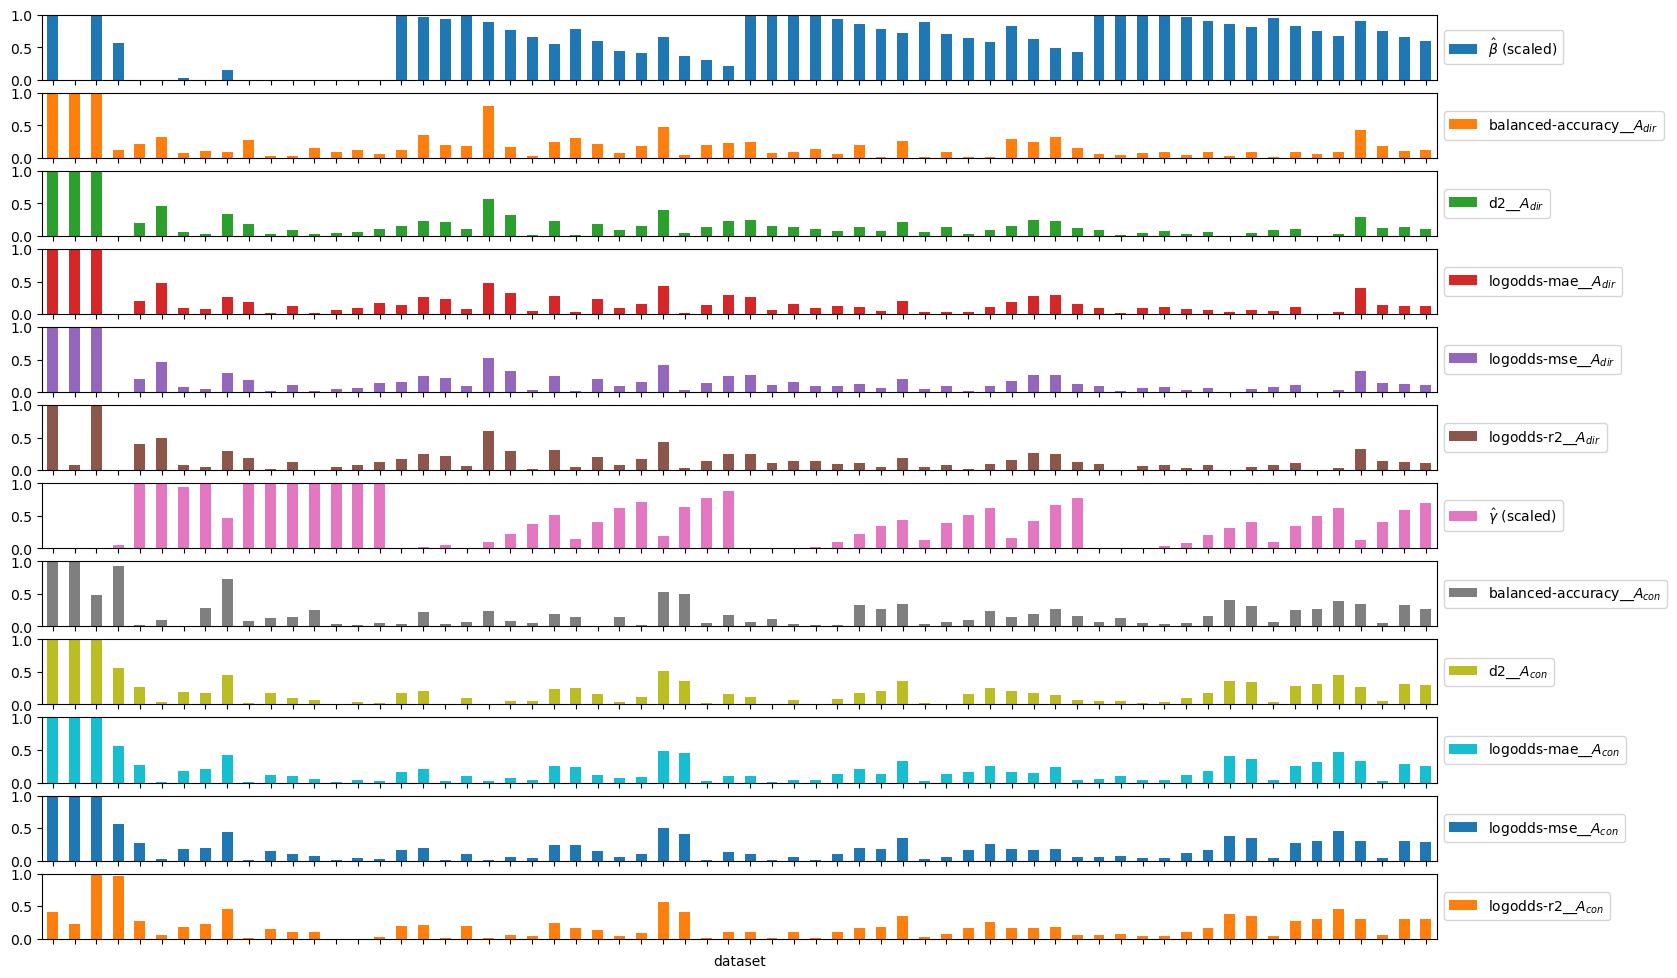

In [ ]:
# plot the deviations
df_deviations.plot(kind='bar', figsize=(18, 12), 
                    subplots=True, sharex=True, sharey=True, legend=True, ylim=(0,1))
for ax in plt.gcf().axes:
    ax.set_title('')
    ax.set_xticklabels([])
    # move legend outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Spearman correlations between different OOD scores vs true configured effect sizes

In [ ]:
# check the correlation with beta_true, gamma_true, alpha_true 
df_deviations[[r'$\alpha_{true}$', r'$\gamma_{true}$', r'$\beta_{true}$']] = (df_out_plt[[r'$\alpha_{true}$', r'$\gamma_{true}$', r'$\beta_{true}$']])
df_deviations.corr(method='spearman').abs()[[r'$\alpha_{true}$', r'$\gamma_{true}$', r'$\beta_{true}$']].style.background_gradient(cmap='Greys_r', axis=None).format("{:.2f}")

,$\alpha_{true}$,$\gamma_{true}$,$\beta_{true}$
$\hat{\beta}$ (scaled),0.24,0.58,0.58
balanced-accuracy__$A_{dir}$,0.17,0.00,0.31
d2__$A_{dir}$,0.24,0.05,0.25
logodds-mae__$A_{dir}$,0.13,0.03,0.26
logodds-mse__$A_{dir}$,0.20,0.03,0.26
logodds-r2__$A_{dir}$,0.19,0.00,0.23
$\hat{\gamma}$ (scaled),0.33,0.70,0.36
balanced-accuracy__$A_{con}$,0.05,0.11,0.04
d2__$A_{con}$,0.03,0.03,0.01
logodds-mae__$A_{con}$,0.02,0.01,0.05


In [ ]:
# compare correlations with datasets_selected
df_deviations_selected = df_deviations.iloc[datasets_selected_idx]
df_deviations_selected.corr(method='spearman').abs()[[r'$\alpha_{true}$', r'$\gamma_{true}$', r'$\beta_{true}$']].style.background_gradient(cmap='Greys_r', axis=None).format("{:.2f}")

,$\alpha_{true}$,$\gamma_{true}$,$\beta_{true}$
$\hat{\beta}$ (scaled),0.43,0.75,0.62
balanced-accuracy__$A_{dir}$,0.01,0.22,0.15
d2__$A_{dir}$,0.09,0.11,0.27
logodds-mae__$A_{dir}$,0.05,0.15,0.25
logodds-mse__$A_{dir}$,0.04,0.15,0.27
logodds-r2__$A_{dir}$,0.01,0.12,0.28
$\hat{\gamma}$ (scaled),0.49,0.75,0.52
balanced-accuracy__$A_{con}$,0.18,0.25,0.34
d2__$A_{con}$,0.15,0.19,0.32
logodds-mae__$A_{con}$,0.10,0.13,0.38


# Conclusion: Irrespective of which accuracy metric is used, the OOD accuracies can be used to recover the true learned effect sizes $\{\hat{\beta}, \hat{\gamma}\}$, given that $A_{total}$ is significant. 


![Figure: Simplest linear case](../figures/toybrains_estimation.png)
This figure proves 3 things:
1. OOD performance ratios reflect the true effect ratios given,
   1. the $\gamma \cdot l_{c_k} \approx \theta \cdot c_k$ , that is in our simulation $\sigma(\alpha) \rightarrow 1$. Keep $\alpha$ high ($\alpha>3$) so that all the effects of $c_k$ translate into $l_{c_k}$ deterministically. That is $p(l_{c_k}\texttt{=}s) = \sigma(\alpha \cdot c_k)$  becomes $p(l_{c_k}\texttt{=}s)= 1 \text{ if } c_k > 0.$ This also ensures the latent variables $l_{c_k}$ and $l_{dir}$ are 'identifiable' (refers to the ability to uniquely determine the model parameters from the observed data) and therefore can be recovered without error from the data.
   2. We must keep $p(y) = \sigma(\beta \cdot l_{dir} + \gamma \cdot c_k)$ bounded away from the extreme values (0 and 1) by constraining $0<(|\beta \cdot \gamma|)<2$. This is necessary because using extreme values of $\beta$ and $\gamma$ causes the following challenges for the estimation:
       1. Variance of $y$ approaches to zero: Large values of $\beta$ and $\gamma$ in the data-generating process lead to extreme values of the probabilities $p(y)$, when it become very close to 0 or 1.Therefore, the variance of the Bernoulli distribution  $p(y)(1 -  p(y))$ approaches zero. This leads to less variability in the response variable $y$ reducing the information available for estimating the parameters.
       2. Quasi-Separation occurs when the data almost perfectly predict the outcome. The MLE exists but is biased and can be very large in magnitude.
       3. Non-Linearity of the Logit Function: The logistic function is non-linear, and its curvature can contribute to estimation bias when parameters are large.
   3. Sample size should be large enough. We use a GLM to estimate the effect sizes learned by $f_{\Theta}$ for the confounds and the direct effect by fitting $\sigma^{-1} p(y) = \hat{\beta} \cdot l_{dir} + \sum_{\forall k} \gamma \cdot c_k$. 'MLE of GLM are asymptotically unbiased', that is, the expected value of the estimator equals the true parameter value when the sample size used approaches infinity. In finite samples, especially small ones, the MLE can exhibit bias (In logistic regression, finite sample bias often causes the estimated coefficients to be biased away from zero i.e., their absolute values are overestimated).. This bias does not necessarily disappear unless the sample size is sufficiently large. 
   
